<a href="https://colab.research.google.com/github/sravika-reddy12/Sravika-Reddy_INFO5731_Spring2023/blob/main/Exercise%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Write your code here

!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 17.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv("data.csv")

#Cleaning the data
import re

def cleantext(tweets):
    text = re.sub(r'@[A-Za-z0-9_]+', '', tweets) #removes @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) #removing Hashtag symbols.
    text = re.sub(r'RT[\s]+', '', text) #removing Retweet symbol (RT).
    text = re.sub(r'https?:\/\/\S+', '', text) #remove URL's.
    text = re.sub(r"www.\S+", "", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^A-Za-z0-9]"," ", text)#Filtering non-alphanumeric characters
    text = re.sub('\\n', '', text)#removing the '\n' character
    text = re.sub(r'[0-9]+', '', text)#removing numbers
    
    return text

df["Text"] = df["Text"].apply(cleantext)

# Convert to list
data = df.Text.values.tolist()

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
b = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
t = gensim.models.Phrases(b[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bmod = gensim.models.phrases.Phraser(b)
tmod = gensim.models.phrases.Phraser(t)

# See trigram example
print(tmod[bmod[data_words[0]]])

['optimistic', 'about', 'our', 'ability', 'to', 'prevent', 'the', 'next', 'pandemic', 'we', 'have', 'learned', 'so', 'much', 'from', 'covid', 'and', 'the', 'innovations', 'have', 'been', 'tremendous']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bmod[doc] for doc in texts]

def make_trigrams(texts):
    return [tmod[bmod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['optimistic', 'ability', 'prevent', 'next', 'pandemic', 'learn', 'much', 'covid', 'innovation', 'tremendous']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('ability', 1),
  ('covid', 1),
  ('innovation', 1),
  ('learn', 1),
  ('much', 1),
  ('next', 1),
  ('optimistic', 1),
  ('pandemic', 1),
  ('prevent', 1),
  ('tremendous', 1)]]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.041*"young" + 0.026*"opportunity" + 0.026*"ask" + 0.021*"million" + '
  '0.021*"community" + 0.021*"power" + 0.020*"life" + 0.019*"generation" + '
  '0.019*"question" + 0.018*"worker"'),
 (1,
  '0.102*"book" + 0.062*"read" + 0.029*"keep" + 0.021*"conversation" + '
  '0.021*"late" + 0.016*"tackle" + 0.016*"thank" + 0.015*"author" + '
  '0.014*"partnership" + 0.014*"favorite"'),
 (2,
  '0.039*"new" + 0.031*"good" + 0.030*"work" + 0.026*"need" + 0.024*"get" + '
  '0.020*"investment" + 0.019*"learn" + 0.019*"help" + 0.019*"global" + '
  '0.018*"important"'),
 (3,
  '0.031*"life" + 0.029*"help" + 0.028*"great" + 0.025*"way" + '
  '0.020*"pandemic" + 0.017*"take" + 0.017*"covid" + 0.016*"thing" + '
  '0.015*"even" + 0.014*"well"'),
 (4,
  '0.035*"inspire" + 0.027*"work" + 0.023*"year" + 0.022*"live" + '
  '0.021*"change" + 0.017*"government" + 0.016*"save" + 0.016*"meet" + '
  '0.015*"team" + 0.014*"never"'),
 (5,
  '0.075*"world" + 0.047*"people" + 0.038*"make" + 0.031*"year" + '


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.412594668358864

Coherence Score:  0.3761221366588604


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.171877  0.262794       1        1  19.133325
2      0.205056 -0.196207       2        1  17.208745
3      0.177264  0.005745       3        1  14.266425
4     -0.176659  0.026600       4        1   9.396337
8     -0.040275  0.132458       5        1   9.064105
6     -0.006168 -0.180057       6        1   8.672361
9     -0.049672 -0.016599       7        1   7.867079
0     -0.073140 -0.048051       8        1   6.811537
1     -0.114332  0.005775       9        1   4.562512
7     -0.093951  0.007541      10        1   3.017576, topic_info=               Term        Freq       Total Category  logprob  loglift
65            world  194.000000  194.000000  Default  30.0000  30.0000
204  climate_change   82.000000   82.000000  Default  29.0000  29.0000
414            book   59.000000   59.000000  Default  28.0000  28.0000
33           people  121.000000  121.000000  Default  27.0000  27.0000
23             year  126.000000  126.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
869          course    2.035117    2.815841  Topic10  -5.2350   3.1760
767      administer    1.991057    2.771737  Topic10  -5.2569   3.1699
296         develop    4.873391   22.828146  Topic10  -4.3618   1.9565
78          country    4.845324   67.630914  Topic10  -4.3676   0.8647
60             live    3.549758   30.057547  Topic10  -4.6787   1.3645

[421 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         9  0.895109      ability
119       2  0.306676   accelerate
119       6  0.690021   accelerate
850      10  0.853211  accelerator
366       9  0.826915       access
...     ...       ...          ...
23        1  0.602441         year
23        4  0.221952         year
23        5  0.174391         year
2155      6  0.846051        yield
175       8  0.988083        young

[457 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 4, 5, 9, 7, 10, 1, 2, 8])

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

NotImplementedError: ignored

In [ ]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

NameError: ignored

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

In [ ]:
 # Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

NameError: ignored

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2212
Num Topics = 4  has Coherence Value of 0.2767
Num Topics = 6  has Coherence Value of 0.3327
Num Topics = 8  has Coherence Value of 0.3458
Num Topics = 10  has Coherence Value of 0.4085
Num Topics = 12  has Coherence Value of 0.4148
Num Topics = 14  has Coherence Value of 0.447
Num Topics = 16  has Coherence Value of 0.4598
Num Topics = 18  has Coherence Value of 0.4681
Num Topics = 20  has Coherence Value of 0.4855
Num Topics = 22  has Coherence Value of 0.5015
Num Topics = 24  has Coherence Value of 0.5136
Num Topics = 26  has Coherence Value of 0.5292
Num Topics = 28  has Coherence Value of 0.5451
Num Topics = 30  has Coherence Value of 0.5557
Num Topics = 32  has Coherence Value of 0.55
Num Topics = 34  has Coherence Value of 0.5639
Num Topics = 36  has Coherence Value of 0.5752
Num Topics = 38  has Coherence Value of 0.5859


In [ ]:
# Select the model and print the topics
optimal_model = model_list[14]
#model_list[4] indicates that: model_list is a list that has been defined earlier and contains the number of topics and its coherence values.
# Since I have decided 10 to be the ideal number of topics, Topics number 30 is present in the 14th place of the list.
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

NameError: ignored

ONE Done


## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:


In [ ]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
# Write your code here
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
preprocess_data(data)





[['optimist',
  'abil',
  'prevent',
  'next',
  'pandem',
  'learn',
  'much',
  'covid',
  'innov',
  'tremend'],
 ['global',
  'fund',
  'one',
  'best',
  'invest',
  'global',
  'health',
  'fulli',
  'fund',
  'program',
  'next',
  'year',
  'critic',
  'end',
  'hiv',
  'tb',
  'malaria',
  'help',
  'ensur',
  'covid',
  'last',
  'pandem'],
 ['end',
  'day',
  'paul',
  'last',
  'impact',
  'found',
  'patient',
  'love',
  'dearli',
  'peopl',
  'aliv',
  'today',
  'dedic',
  'life',
  'help'],
 ['work',
  'continu',
  'partner',
  'health',
  'incred',
  'organ',
  'co',
  'found',
  'phenomen',
  'legaci'],
 ['paul',
  'never',
  'happier',
  'care',
  'patient',
  'one',
  'clinic',
  'help',
  'creat',
  'heart',
  'goe',
  'famili',
  'friend',
  'colleagu',
  'peopl',
  'whose',
  'live',
  'touch'],
 ['devast',
  'loss',
  'paul',
  'hero',
  'fortun',
  'call',
  'friend',
  'never',
  'known',
  'anyon',
  'passion',
  'reduc',
  'world',
  'worst',
  'inequ',
  '

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
number_of_topics=7
words=10

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

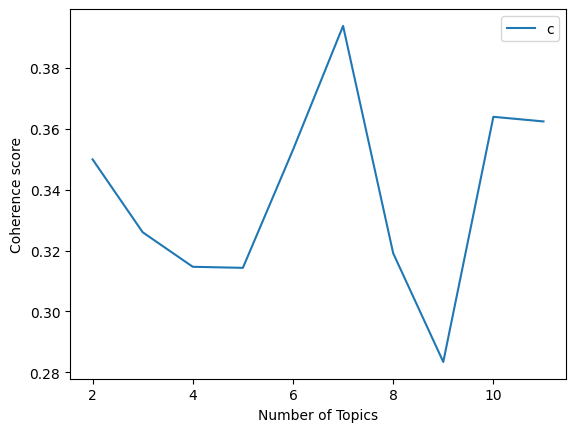

In [ ]:
start,stop,step=2,12,1
plot_graph(preprocess_data(data),start,stop,step)

In [ ]:
# Write your code here
model=create_gensim_lsa_model(preprocess_data(data),number_of_topics,words)

[(0, '0.361*"world" + 0.306*"climat" + 0.235*"work" + 0.221*"chang" + 0.185*"help" + 0.179*"need" + 0.176*"one" + 0.153*"peopl" + 0.152*"year" + 0.143*"make"'), (1, '-0.574*"climat" + -0.376*"chang" + 0.216*"health" + 0.174*"year" + 0.164*"countri" + -0.156*"avoid" + -0.142*"disast" + -0.138*"energi" + -0.130*"need" + 0.127*"vaccin"'), (2, '0.577*"world" + -0.472*"year" + -0.342*"one" + -0.219*"book" + -0.155*"new" + 0.142*"health" + -0.132*"read" + -0.097*"lot" + 0.094*"around" + -0.091*"learn"'), (3, '0.527*"world" + -0.244*"countri" + 0.227*"year" + -0.218*"health" + -0.207*"need" + -0.192*"help" + -0.189*"vaccin" + -0.188*"pandem" + 0.151*"one" + -0.148*"covid"'), (4, '0.637*"work" + -0.331*"one" + 0.214*"year" + -0.204*"help" + 0.193*"health" + -0.171*"peopl" + -0.151*"new" + -0.148*"world" + -0.104*"diseas" + -0.102*"book"'), (5, '-0.306*"chang" + 0.282*"make" + 0.261*"energi" + 0.260*"new" + -0.243*"one" + -0.228*"climat" + -0.223*"peopl" + -0.173*"countri" + 0.170*"zero" + 0.16

##(3) (10 points) Generate K topics by using lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:
https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [ ]:
!pip install lda2vec

NotImplementedError: ignored

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:
https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [ ]:
# Write your code here

%%capture
!pip install bertopic



In [ ]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
print(docs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

2023-04-03 00:02:52,583 - BERTopic - Transformed documents to Embeddings
2023-04-03 00:03:30,264 - BERTopic - Reduced dimensionality
2023-04-03 00:04:09,945 - BERTopic - Clustered reduced embeddings


In [ ]:
freq = topic_model.get_topic_info(); freq.head(5)


,Topic,Count,Name
0,-1,6713,-1_to_is_the_of
1,0,1828,0_game_team_games_he
2,1,598,1_key_clipper_chip_encryption
3,2,524,2_ites_cheek_yep_huh
4,3,344,3_israel_israeli_arab_arabs


In [ ]:
topic_model.get_topic(0)  # Select the most frequent topic

[('game', 0.010361821198650437),
 ('team', 0.009030078443609571),
 ('games', 0.007195763183234356),
 ('he', 0.006987909804014962),
 ('players', 0.006326683052291026),
 ('season', 0.006232971417981594),
 ('hockey', 0.0061341159151912525),
 ('play', 0.0057769910748635255),
 ('25', 0.0056489362287736825),
 ('year', 0.00560065660258025)]

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

##(5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [30]:
'''The idea of Topic Coherence can be used to assess Topic Modelling. To get topic models, a variety of strategies are employed. Latent Dirichlet Allocation (LDA) and Latent Semantic Analysis (LSA) are the two.
LDA:
The dictionary and the corpus are the LDA topic model's two primary inputs. Each word in the document receives a distinct id from Gensim. The number of topics must be provided in addition to the corpus and dictionary.
By attempting a few different themes and contrasting the results, we may use the LDA visualization tool pyLDAvis.
One of the primary methods used to determine the number of subjects is topic coherence.
We must construct numerous LDA models with various values for the number of topics (k), then select the model that yields the highest coherence value.

LSA: LSA is frequently applied as a noise- or dimension-reduction approach.
The most effective method for figuring out k (the number of topics) in topic modeling is to use the topic coherence measure, which is a practical technique to count the number of topics.
The topic model will be deemed to have a high topic coherence score value.
The LSA algorithm's optimal coherence score for the plot, which is the coherence value and number of topics, is seen at 0,54 with topic at 6.

LDA produces superior results than LSA, according to the analysis.'''


"The idea of Topic Coherence can be used to assess Topic Modelling. To get topic models, a variety of strategies are employed. Latent Dirichlet Allocation (LDA) and Latent Semantic Analysis (LSA) are the two.\nLDA:\nThe dictionary and the corpus are the LDA topic model's two primary inputs. Each word in the document receives a distinct id from Gensim. The number of topics must be provided in addition to the corpus and dictionary.\nBy attempting a few different themes and contrasting the results, we may use the LDA visualization tool pyLDAvis.\nOne of the primary methods used to determine the number of subjects is topic coherence.\nWe must construct numerous LDA models with various values for the number of topics (k), then select the model that yields the highest coherence value.\n\nLSA: LSA is frequently applied as a noise- or dimension-reduction approach.\nThe most effective method for figuring out k (the number of topics) in topic modeling is to use the topic coherence measure, which